In [1]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from astropy.io import (
    fits,
    ascii,
)

from skimage.measure import centroid

import copy

from lina.phase_retrieval import ADPR, FDPR, BBPR
from lina.utils import TikhonovInverse

import config_um
import config_um_wcc
from Batoid4LOFT.LAZULI_STOP import Lazuli_stop, readBulkMotion, readDeformation

from psd_utils import PSDUtils

from scipy.optimize import minimize

from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm

from psd_utils import PSDUtils

from model import off_axis_3m_TMA
from algos import FFPR
import utils

# logging stuff
import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# init model

In [2]:
cfg_um = config_um.load_config_values('unitless')
cfg_um_wcc = config_um_wcc.load_config_values('unitless')

path_um = config_um.get_data_path()
path_um_wcc = config_um_wcc.get_data_path() + '/'

In [3]:
opd_maps = utils.load_pickle('/home/derbyk/src/ffpr/data/opd_maps.pkl')

In [4]:
detector_data = utils.load_pickle('/home/derbyk/src/ffpr/data/detector_data.pkl')

In [8]:
platescale = 4.905 # arcsec/mm

w = 36 * platescale / 60
h = 24 * platescale / 60
w_offset = w / 2
h_offset = h / 2

positions = [(data['xy'][0] + w_offset, data['xy'][1] + h_offset) for data in detector_data]
defocuses = [float(data['defocus']) for data in detector_data]

source_inds = [1, 5, 10, 13]

positions = [positions[i] for i in source_inds]
defocuses = [-2., 2., 0., 2.] # [defocuses[i] for i in source_inds]

In [9]:
sys = off_axis_3m_TMA(opd_maps=opd_maps, config_stp=cfg_um, config_wcc=cfg_um_wcc,
                      data_path_stp=path_um, data_path_wcc=path_um_wcc)

# lots n lots o stars
mags = (np.ones(len(positions)) * 18).tolist()
# positions = [(-6,  3), (0,  3), (6,  3),
#              (-12,  0), (0,  0), (12,  0),
#              (-12, -3), (0, -3), (12, -3),]
# defocuses = [1., -1.,  1.,
#               -1.,   0.,   -1.,
#              1.,  -1., 1.]
sys.set_source_parameters(magnitudes=mags, positions=positions, defocus_vals=defocuses)

sys.exp_time = 20

In [10]:
images = sys.snap(stacked_frames=25)

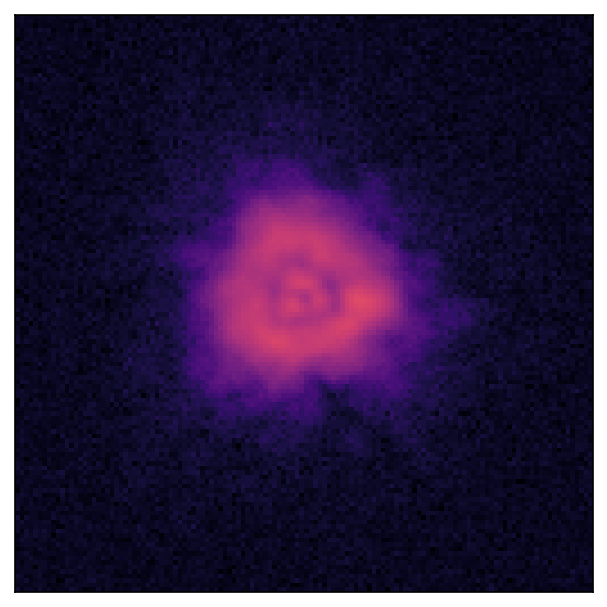

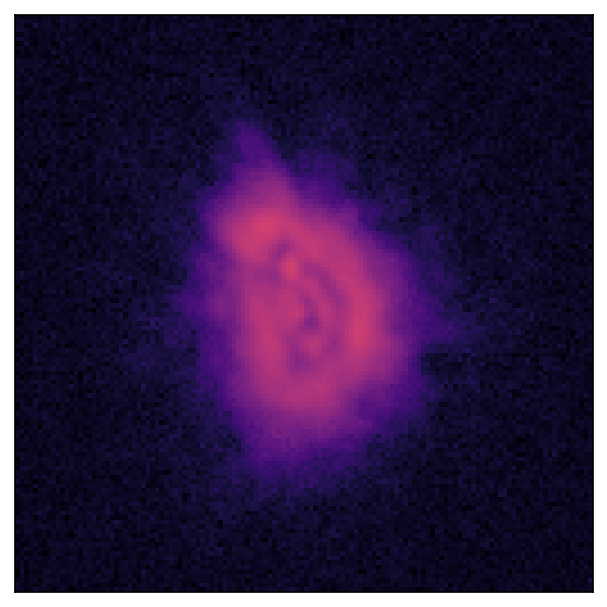

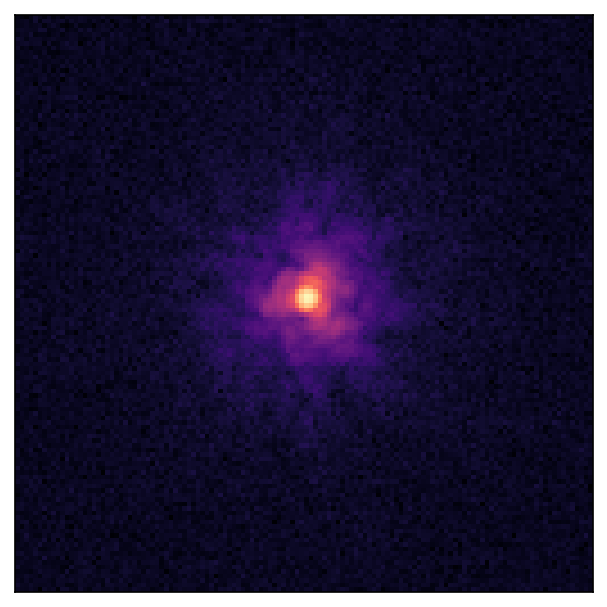

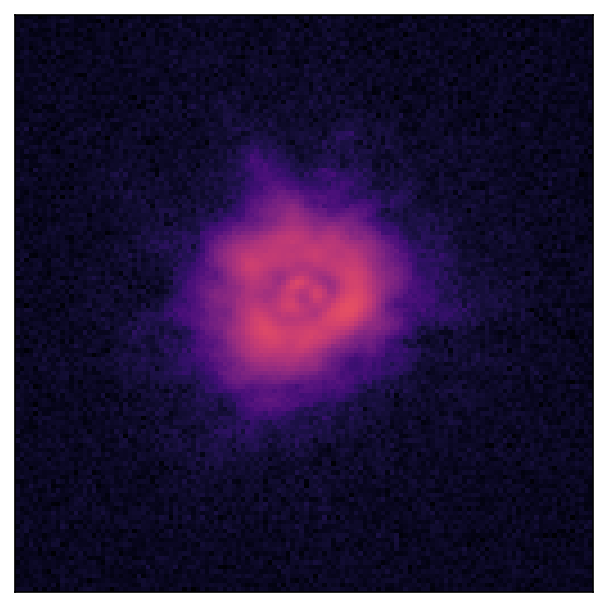

In [11]:
for im in images:
    plt.figure(figsize=(5, 5), dpi=150)
    plt.imshow(im.get(), cmap='magma', norm='log', vmax=sys.well_depth, vmin=1)
    plt.xticks([])
    plt.yticks([])

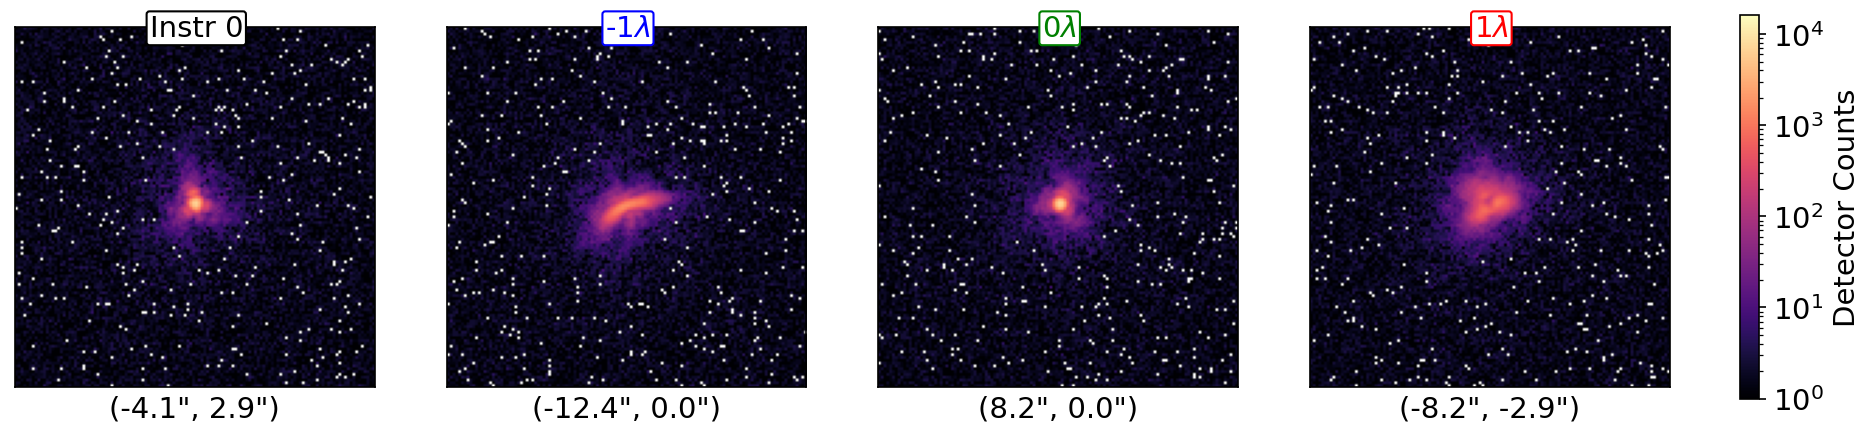

In [44]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 4), dpi=150)

count = 0
lol = 0
for i, ax in enumerate(axs.flat):
    im = ax.imshow(images[count].get(), cmap='magma', norm='log', vmax=sys.well_depth, vmin=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel(f'({sys.src_pos[count][0] * 60:.01f}", {sys.src_pos[count][1] * 60:.01f}")', fontsize=14)

    if defocuses[count] == -1:
        c = "blue"
    elif defocuses[count] == 0:
        c = "green"
    elif defocuses[count] == 1:
        c = "red"
    l = f'{defocuses[count]:.0f}$\lambda$'

    if count == 0:
        c = "black"
        l = f"Instr {lol:.0f}"
        lol += 1

    ax.text(64, 132, l,
            color=c, fontsize=14,
            ha='center', va='top',
            bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
    
    count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.011, pad=0.04, label='Detector Counts')
cb.set_label('Detector Counts', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True


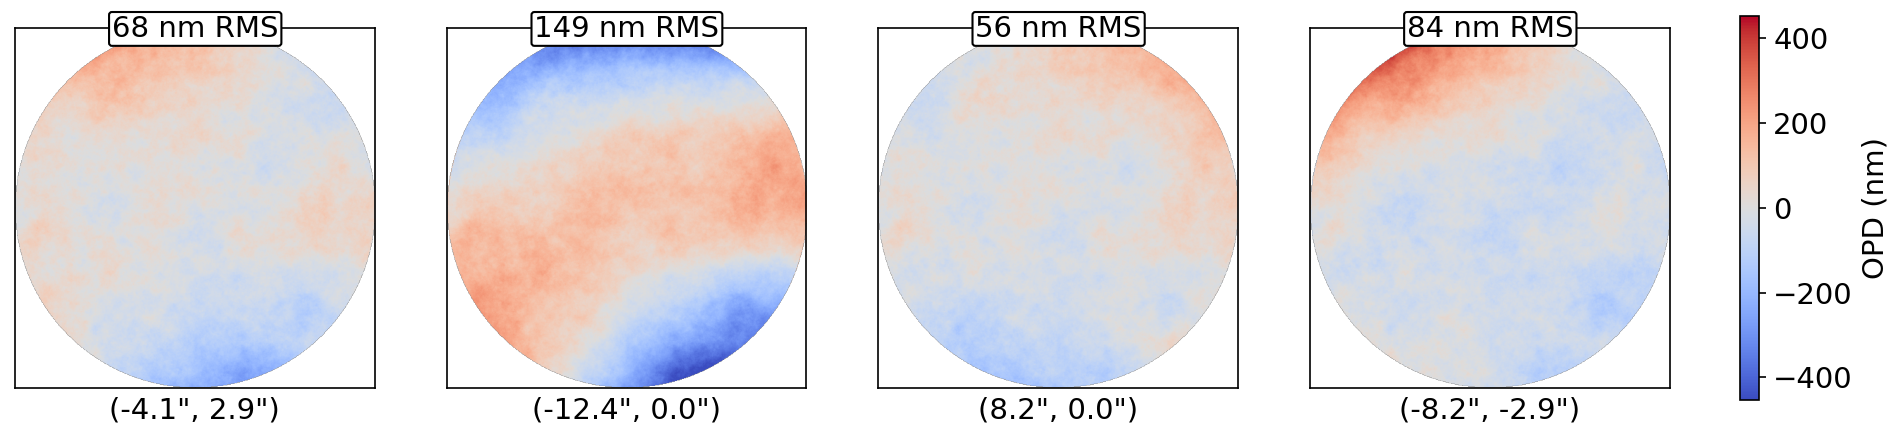

In [45]:
opds = sys.get_opds()['Field']

optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0)

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)

v1 = np.nanmax(np.array(opds))
v2 = np.abs(np.nanmin(np.array(opds)))
v = np.max(np.array([v1, v2]))

opds = [opd + optic_opd for opd in opds]

for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5), dpi=150)

count = 0
for i, ax in enumerate(axs.flat):
        
    im = ax.imshow(opds[count].get(), cmap='coolwarm', vmax=v, vmin=-v)
    ax.set_xticks([])
    ax.set_yticks([])        

    ax.set_xlabel(f'({sys.src_pos[count][0] * 60:.01f}", {sys.src_pos[count][1] * 60:.01f}")', fontsize=14)

    l = f'{rms_vals[count]:.0f} nm RMS'
    c = "black"

    ax.text(256, 530, l,
            color=c, fontsize=14,
            ha='center', va='top',
            bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
    
    count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.011, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True


Text(0.5, 1.0, 'M1 - M4 Optic Surface Errors\n27.20 nm RMS')

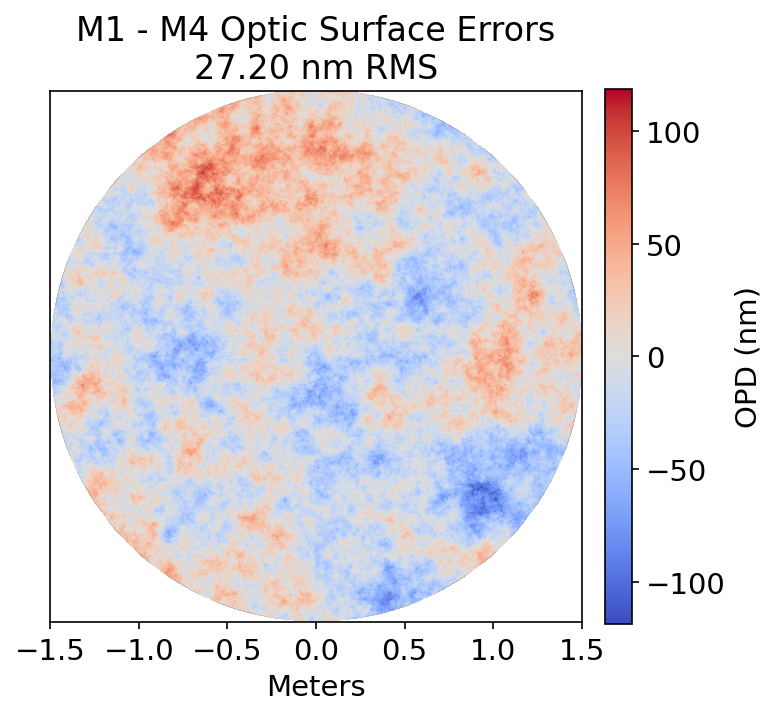

In [46]:
optic_opd[~sys.pupil] = np.nan

v1 = np.nanmax(optic_opd)
v2 = np.abs(np.nanmin(optic_opd))
v = np.max(np.array([v1, v2]))

plt.figure(figsize=(5, 5), dpi=150)
im = plt.imshow(optic_opd.get(), cmap='coolwarm', vmin=-v, vmax=v, extent=[-1.5, 1.5, -1.5, 1.5])
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
plt.xlabel('Meters', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.title(f'M1 - M4 Optic Surface Errors\n{np.sqrt(np.nanmean(optic_opd[sys.pupil] ** 2)):.2f} nm RMS', fontsize=16)

# field stuff

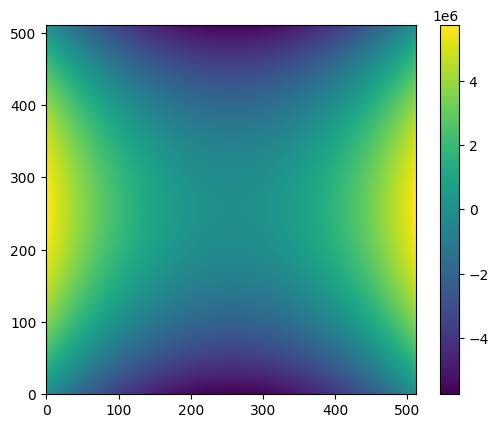

In [22]:
plt.imshow(zernikes[4].get())
plt.colorbar()

In [27]:
raytrace = Lazuli_stop()

# zernike basis (excluding piston) up to Z37
x, y = make_xy_grid(sys.pupil.shape[0], dx=sys.dx_pup)
r, t = cart_to_polar(x, y)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# indices for the zernikes which exhibit field dependence that changes with alignment: defocus, coma, astig, trefoil, spherical
# THESE DO NOT CORRESPOND TO NOLL INDICES
inds = [i + 2 for i in range(8)]

# field positions to evaluate
fields_x = np.linspace(-16.2, 16.2, 17) / 60 # +/- 16.2 arcmin in x
fields_y = np.linspace(-4.8, 4.8, 5) / 60  # +/- 4.8 arcmin in y

# initialize array to hold coeffs for field-dependent zernikes at nominal alignment
field_coeffs_nom = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=sys.pupil.shape[0])
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~sys.pupil] = np.nan

        # decompose
        field_coeffs_nom[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

# create interpolators for field-dependent zernikes
field_interps_nom = [interpolate.RegularGridInterpolator((fields_x, fields_y), field_coeffs_nom[i, :, :], method='cubic') for i in range(field_coeffs_nom.shape[0])]

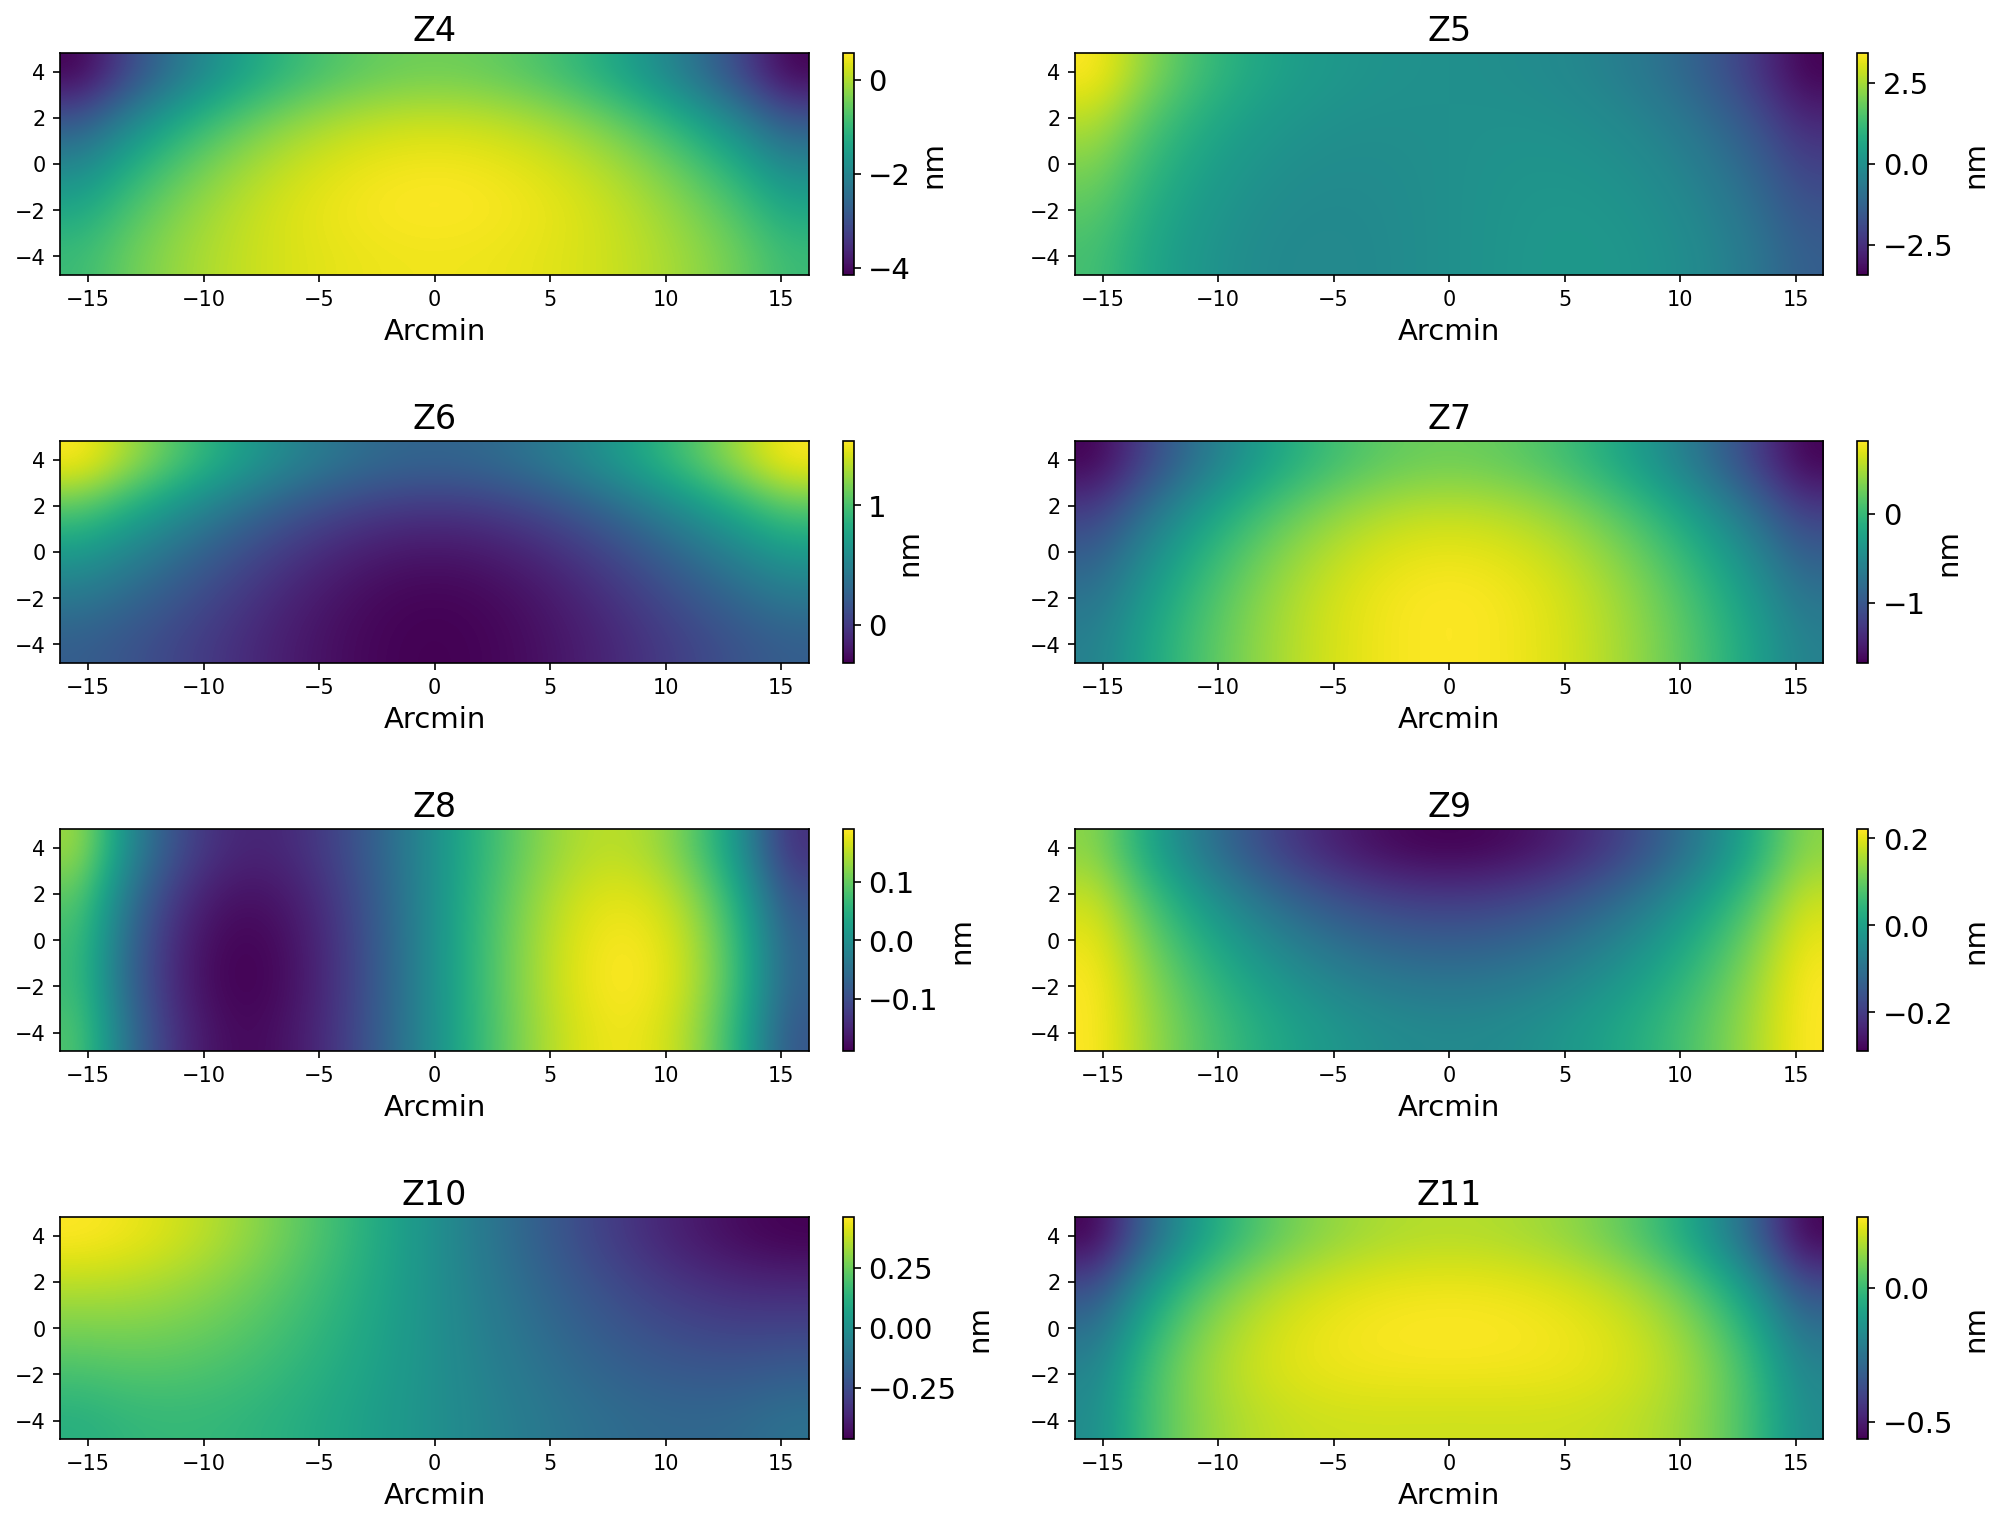

In [39]:
# show field dependence for field-dependent zernikes
plt.figure(figsize=(16, 12), dpi=150)
for i in range(field_coeffs_nom.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}', fontsize=16)
    plt.imshow(field_coeffs_nom[i, :, :].get().T / 625, interpolation='bicubic', extent=[-16.2, 16.2, -4.8, 4.8])
    plt.xlabel('Arcmin', fontsize=14)
    cb = plt.colorbar(fraction=0.014, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    cb.set_label('nm', fontsize=14)

plt.subplots_adjust(hspace=0.75)